In [176]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [177]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [178]:
# Configurar para usar solo la memoria necesaria
# physical_devices = tf.config.list_physical_devices('GPU')
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     print('done')

In [179]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [180]:
P0_exp=df2.iloc[:, -5:]
P1_exp=df2.iloc[:, 3:9]
P2_exp=df2.iloc[:, 9:14]
P3_exp=df2.iloc[:, [15,19,20]]


P0_exp, P1_exp, P2_exp, P3_exp


(0        H7      H8      H9     H10     H11
 0    0.0921   0.092   0.093  0.0927   0.093
 1    0.0921  0.0921  0.0931  0.0932  0.0925
 2    0.0922  0.0923  0.0932  0.0932  0.0927
 3    0.0928  0.0926  0.0936  0.0937   0.093
 4    0.0933  0.0933  0.0943  0.0944  0.0938
 ..      ...     ...     ...     ...     ...
 337  1.0018  0.9769  0.9848  0.9871  0.9972
 338  1.0017    0.98  0.9857  0.9868  0.9976
 339  1.0009  0.9758  0.9833  0.9846  0.9963
 340  1.0004  0.9763  0.9843  0.9845  0.9981
 341  1.0014  0.9772  0.9853  0.9843  0.9956
 
 [342 rows x 5 columns],
 0        A1      A2      A3      A4      A5      A6
 0    0.0929  0.0971  0.0948  0.0961  0.0939  0.0934
 1    0.0925  0.0962  0.0946  0.0953  0.0935  0.0931
 2    0.0926  0.0962   0.095  0.0954  0.0936  0.0932
 3    0.0928  0.0981  0.0949  0.0956  0.0937  0.0934
 4    0.0933  0.0985  0.0953   0.096  0.0942  0.0939
 ..      ...     ...     ...     ...     ...     ...
 337  0.5954  0.6453  0.6513  0.6593  0.6599  0.6576
 338  0.5

In [181]:
P2_exp.shape

(342, 5)

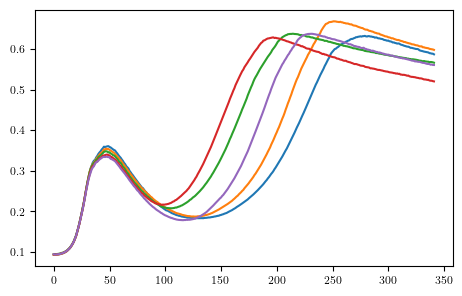

In [182]:
plt.plot(P2_exp)

In [183]:
P1_exp.shape

(342, 6)

In [184]:
c=-1
P_exp=np.hstack((P0_exp,P1_exp,P2_exp,P3_exp))
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
n=np.array([P0_exp.shape[1],P1_exp.shape[1],P2_exp.shape[1],P3_exp.shape[1],])
A=np.array([0, 1.25, 2.50, 3.75])
N_exp,T_max, T_exp.shape, P_exp.shape, 342*23

(19, 231399.5, (342,), (342, 19), 7866)

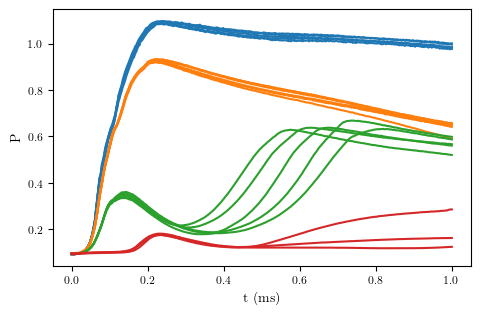

In [185]:
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)

plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

In [186]:
N_f = 1000 # Number of residual point
N_d = 1500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
Xa_star=[]
P0_star=np.empty((0, 1))
X_star = np.empty((0, 3))
for i in range(len(A)):
    P0=P_exp[0:1, np.sum(n[:i]):np.sum(n[:i+1])]
    P0_star=np.concatenate((P0_star,P0.T))
    T_meshgrid, P0_meshgrid, A_meshgrid = np.meshgrid(T_exp, P0, A[i])
    x=np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None], A_meshgrid.flatten()[:,None]))
    Xa_star += [x]
    X_star=np.vstack((X_star,x))


u_star=np.hstack((P_star,X_star[:,1:2]))

In [187]:
# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
lb[1]=lb[1]
ub = X_star.max(0) 
ub[1]=ub[1]


# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0_star)).reshape([-1,1]), P0_star.reshape([-1,1]), xx0[...,2:3]))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(3, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

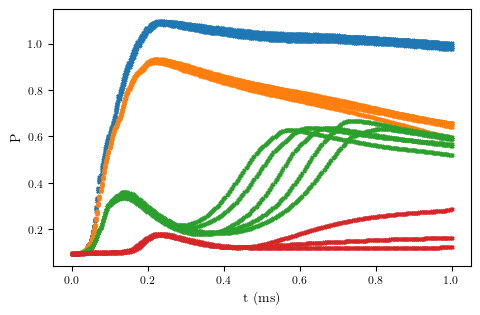

In [188]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=5,  color=color)


plt.xlabel('t (ms)')
plt.ylabel('P')
plt.show()

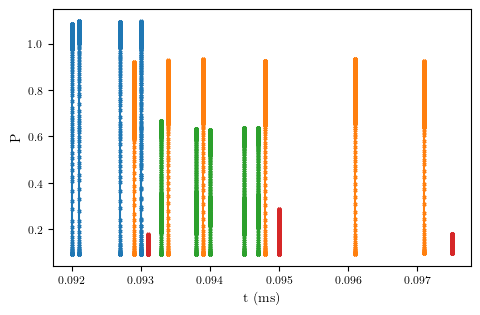

In [189]:
L_exp=len(P_exp[:,1])
for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        plt.plot(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,1],P_exp[:, (i + np.sum(n[:k]))], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,1],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', color=color, s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

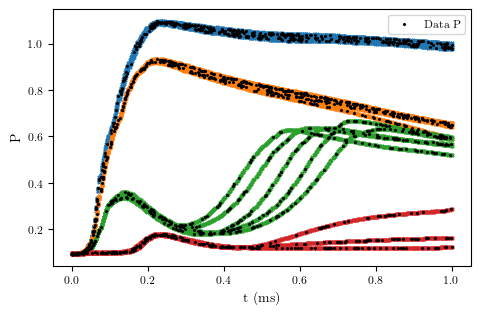

In [190]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],P_star[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=5,  color=color)


plt.xlabel('t (ms)')
plt.ylabel('P')

plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

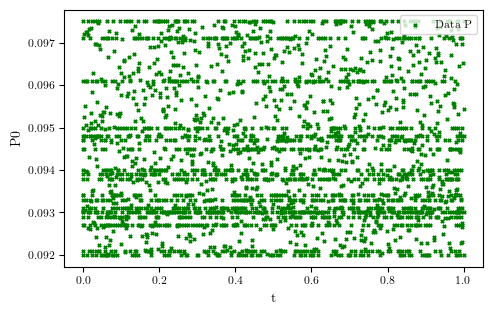

In [191]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
plt.ylabel('P0')
# plt.savefig('figures/P_phi.pdf')
plt.show()

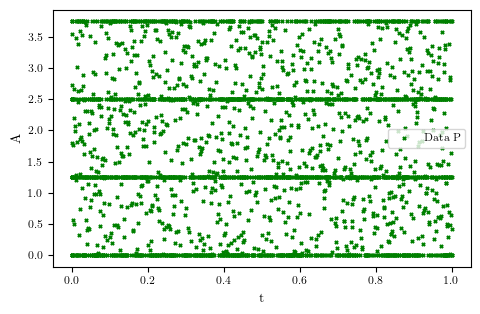

In [192]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,2], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
plt.ylabel('A')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [193]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    # A = 2.0*(X - lb)/(ub - lb) - 1.0
    A=X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 


def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r+N_b, 3]), dtype=tf.float32)
    # alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1)))
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp * 2 * 3), (N_exp * 2, 3))) 
    return alpha_r, alpha_b, alpha_0


#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p, W_phi, b_phi, W_a, b_a, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)

        lnp1=u[:,0:1]
        lnp2=u[:,1:2]
        lns=u[:,2:3]
        lna=u[:,3:4]


        p1=tf.exp(lnp1)
        p2=tf.exp(lnp2)
        s=tf.exp(lns)
        a=tf.exp(lna)


        ms=tf.exp(lnv[0:1])
        ma=tf.exp(lnv[1:2])
        l=tf.exp(lnv[2:3])

        # phi=tf.exp(net(tf.concat([p, s, l],1), W_phi, b_phi))
        phi_s=tf.exp(net(s, W_phi, b_phi))
        phi_a=tf.exp(net(a, W_a, b_a))


    p1_t = tape1.gradient(p1, X_f)[...,0:1]
    p2_t = tape1.gradient(p2, X_f)[...,0:1]
    s_t = tape1.gradient(s, X_f)[...,0:1]
    a_t = tape1.gradient(a, X_f)[...,0:1]


    f_p1 = p1_t - phi_s*p1 + l*p1
    f_p2 = p2_t - phi_s*p2 + phi_a*p2
    f_s = s_t + ms*(p1+p2)*s
    f_a = a_t + ma*p2*a
    
    return f_p1, f_p2, f_s, f_a




#@tf.function()
# @tf.function()
def train_step(W_p, b_p,  W_phi, b_phi,  W_a, b_a,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, opt):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, W_a, b_a, lambda_b, lambda_r, lambda_0, lnv])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp1=u_nn[:,0:1]
        lnp2=u_nn[:,1:2]
        p1_nn=tf.exp(lnp1)
        p2_nn=tf.exp(lnp2)
        f_p1, f_p2, f_s, f_a = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi, W_a, b_a, lnv)

        u_00 = net(xx01_tf, W_p, b_p) 
        
        s_00=tf.exp(u_00[:,2:3])
        a_00=tf.exp(u_00[:N_exp,3:4])


        p2_00=tf.exp(u_00[:,1:2])
        p1_00=tf.exp(u_00[:,0:1])



        loss_p = tf.square(lambda_b*(p1_nn+p2_nn - P_train_tf))
        loss_0s = tf.square(lambda_0[:,0:1]*(s_00 - uu01_tf))
        loss_0p1 = tf.square(lambda_0[:N_exp,1:2]*(p1_00[:N_exp] - uu01_tf[N_exp:])) #p1 al principio peque
        loss_0p2 = tf.square(lambda_0[N_exp:,1:2]*(p2_00[N_exp:] - uu01_tf[N_exp:])) #p2 al final peque
        loss_0a = tf.square(lambda_0[:N_exp:,2:3]*(a_00 - xx01_tf[:N_exp,2:3]))
        loss_fp1 = tf.square(lambda_r[:,0:1]*f_p1) 
        loss_fp2 = tf.square(lambda_r[:,1:2]*f_p2) 
        loss_fs = tf.square(lambda_r[:,2:3]*f_s) 
        loss_fa = tf.square(lambda_r[:,3:4]*f_a) 



        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp1)+ tf.reduce_mean(loss_fp2)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_fa)+ tf.reduce_mean(loss_0s)+ tf.reduce_mean(loss_0a)+ tf.reduce_mean(loss_0p1)+ tf.reduce_mean(loss_0p2)
        # loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp1)+ tf.reduce_mean(loss_fp2)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_fa)+ tf.reduce_mean(loss_0s)+ tf.reduce_mean(loss_0a)+ tf.reduce_mean(loss_0p1)


    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    grads_a = tape.gradient(loss, train_vars(W_a, b_a))

    grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_0 = tape.gradient(loss, lambda_0)


    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    opt.apply_gradients(zip(grads_a, train_vars(W_a, b_a)))

    opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))

   
    return loss, tf.reduce_mean(tf.square((p1_nn+p2_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p1)), tf.reduce_mean(tf.square(f_p2)), tf.reduce_mean(tf.square(f_s)), tf.reduce_mean(tf.square(f_a))


layers = [3, 20, 20, 4]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [1, 20, 20, 1]

W_a = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_a = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [1, 20, 20, 1]
L = len(layers)

W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 3), (3, -1)), dtype=tf.float32) 
lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)



In [194]:
def train_dynamic_step( W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv, opt):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_phi, b_phi, W_a, b_a, lambda_r, lnv])

        f_p, f_s = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi, W_a, b_a, lnv)

        loss_fp = tf.square(lambda_r[0:1]*f_p) 
        loss_fs = tf.square(lambda_r[1:2]*f_s) 


        loss =  tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)


    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    grads_a = tape.gradient(loss, train_vars(W_a, b_a))

    grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)



    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    opt.apply_gradients(zip(grads_a, train_vars(W_a, b_a)))

    opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))

   
    return loss, 0, tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s))

In [195]:
lr = 5e-3




optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/40)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
it=0
loss = []
loss_d = []
loss_fisp1 = []
loss_fisp2 = []
loss_fiss = []
loss_reg=[]
loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, W_a, b_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, W_a, b_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer2)
# train_step_3 = tf.function(train_dynamic_step).get_concrete_function(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv, optimizer2)


In [196]:
Nmax=2*10**5


while it <= Nmax:
    if it<10**5:
        loss_, loss_p, loss_fp1, loss_fp2, loss_fs, loss_fa = train_step_1(W_p, b_p, W_phi, b_phi, W_a, b_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    else:
        loss_, loss_p,  loss_fp1, loss_fp2, loss_fs, loss_fa = train_step_2(W_p, b_p, W_phi, b_phi, W_a, b_a, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # else
        # loss_, loss_p,  loss_fp1, loss_fp2, loss_fs = train_step_3(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp1.append(loss_fp1)
    loss_fisp2.append(loss_fp2)
    loss_fiss.append(loss_fs)
    loss_fisa.append(loss_fa)



    if it % 10 == 0:

        print(f"Iteration is: {it}")
        # print(f"Total loss is: {loss_}")
        # print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p1 is: {loss_fp1}")
        print(f"Physicial loss of p2 is: {loss_fp2}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    it+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Physicial loss of p1 is: 3.431896924972534
Physicial loss of p2 is: 0.038778312504291534
Physicial loss of s is: 23.034299850463867
Iteration is: 10
Physicial loss of p1 is: 0.03557427227497101
Physicial loss of p2 is: 0.1646384745836258
Physicial loss of s is: 1.4226789474487305
Iteration is: 20
Physicial loss of p1 is: 0.02036234736442566
Physicial loss of p2 is: 0.017133397981524467
Physicial loss of s is: 0.012187818065285683
Iteration is: 30
Physicial loss of p1 is: 0.029566118493676186
Physicial loss of p2 is: 0.006993283051997423
Physicial loss of s is: 0.09209376573562622
Iteration is: 40
Physicial loss of p1 is: 0.07173749059438705
Physicial loss of p2 is: 0.017190126702189445
Physicial loss of s is: 0.29772454500198364
Iteration is: 50
Physicial loss of p1 is: 0.05216849967837334
Physicial loss of p2 is: 0.06483287364244461
Physicial loss of s is: 0.5852999091148376
Iteration is: 60
Physicial loss of p1 is: 0.009753013961017132
Physicial loss of p2 is: 0.01768

KeyboardInterrupt: 

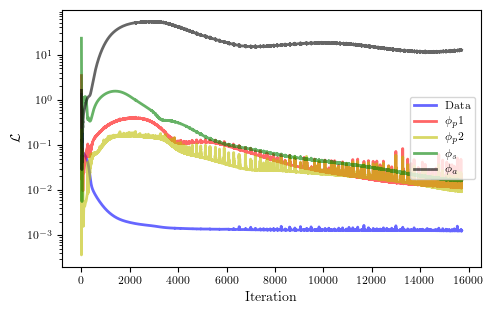

In [197]:
Nmax=len(loss)
ep = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip1_list = [loss_fisp1[i].numpy() for i in range(0,Nmax)]
loss_phip2_list = [loss_fisp2[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]
loss_phia_list = [loss_fisa[i].numpy() for i in range(0,Nmax)]




plt.semilogy(ep, np.asarray(loss_data_list), 'b-', linewidth = 2, alpha=0.6, label = 'Data')  
plt.semilogy(ep, np.asarray(loss_phip1_list), 'r-', linewidth = 2, alpha=0.6, label = '$\phi_p1$') 
plt.semilogy(ep, np.asarray(loss_phip2_list), 'y-', linewidth = 2, alpha=0.6, label = '$\phi_p2$')    
plt.semilogy(ep, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.6, label = '$\phi_s$')    
plt.semilogy(ep, np.asarray(loss_phia_list), 'k-', linewidth = 2, alpha=0.6, label = '$\phi_a$')       



plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [198]:
lnv[0], tf.exp(lnv[0]), lnv[1], tf.exp(lnv[1]), lnv[2], tf.exp(lnv[2])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.9330022], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([51.060043], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.7182817], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.0188231], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([7.529459], dtype=float32)>)

In [199]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)  
# A_star_tf = tf.convert_to_tensor(A, dtype=tf.float32)    

u_pred = predict(X_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp1=u_pred[:,0:1]
lnp2=u_pred[:,1:2]
lns=u_pred[:,2:3]
lna=u_pred[:,3:4]


p1=tf.exp(lnp1)
p2=tf.exp(lnp2)
s=tf.exp(lns)
a=tf.exp(lna)


phi_a=predict(X_star_tf[...,2:3], W_a, b_a)

phi_s=tf.exp(net(s, W_phi, b_phi))
phi_a=tf.exp(net(a, W_a, b_a))

ms=tf.exp(lnv[0:1])
ma=tf.exp(lnv[1:2])
l=tf.exp(lnv[2:3])



s_t=-np.array((p1+p2)*s*ms)
a_t=-np.array(p2*a*ma)



In [200]:
X_star_tf.shape, p1.shape

(TensorShape([6498, 3]), TensorShape([6498, 1]))

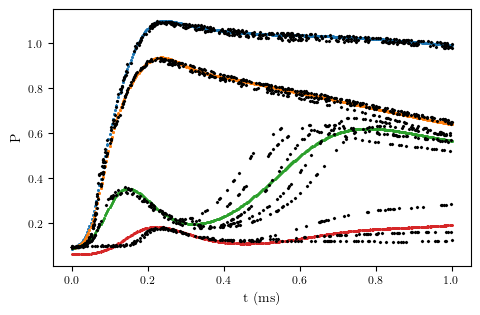

In [201]:


L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],(p1+p2)[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=1,  color=color, label='Prediction P')
plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')



plt.xlabel('t (ms)')
plt.ylabel('P')


# plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

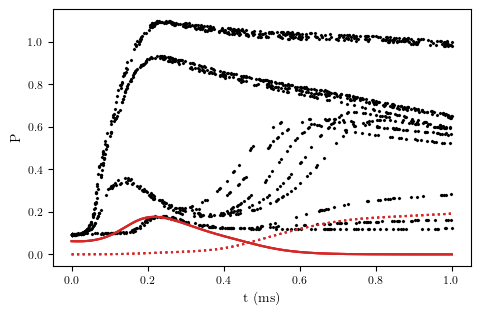

In [202]:


L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

k=3
# Seleccionar el color correspondiente de la paleta
color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
for i in range(j):
    # Aquí puedes pasar el color seleccionado en cada iteración
    # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
    plt.plot(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],p1[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], linestyle=':',  color=color, label='Prediction P')
    plt.plot(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],p2[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)],   color=color, label='Prediction P')

plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')



plt.xlabel('t (ms)')
plt.ylabel('P')


# plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

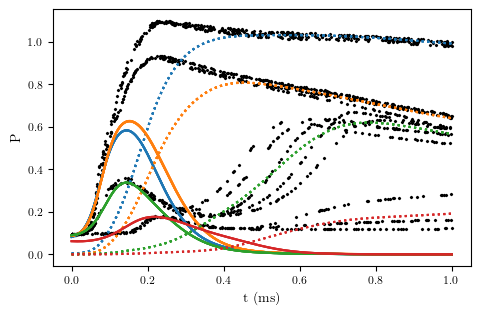

In [203]:
L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.plot(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],p1[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], linestyle=':',  color=color, label='Prediction P')
        plt.plot(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],p2[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)],   color=color, label='Prediction P')

plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')



plt.xlabel('t (ms)')
plt.ylabel('P')


# plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

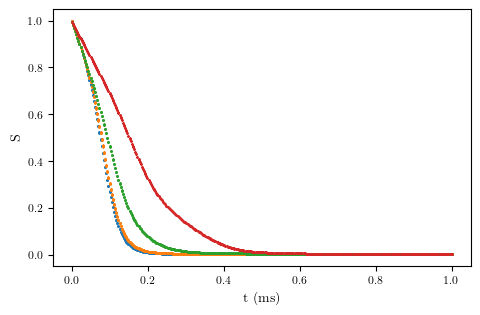

In [204]:


L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],s[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=1,  color=color, label='Prediction P')



plt.xlabel('t (ms)')
plt.ylabel('S')
# plt.yscale('log')

# plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

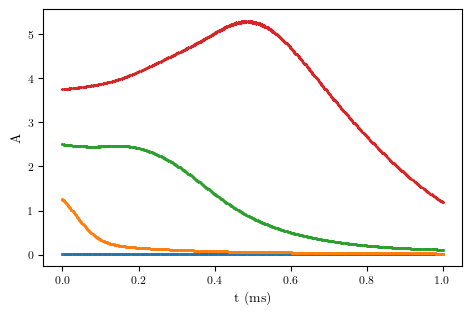

In [205]:


L_exp=len(P_exp[:,1])
colors = plt.cm.tab10.colors

for k, j in enumerate(n):
    # Seleccionar el color correspondiente de la paleta
    color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
    for i in range(j):
        # Aquí puedes pasar el color seleccionado en cada iteración
        # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
        plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,0],a[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', s=1,  color=color, label='Prediction P')



plt.xlabel('t (ms)')
plt.ylabel('A')
# plt.yscale('log')

# plt.legend()

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [ ]:
# L_exp=len(P_exp[:,1])
# colors = plt.cm.tab10.colors

# for k, j in enumerate(n):
#     # Seleccionar el color correspondiente de la paleta
#     color = colors[k % len(colors)]  # Asegurarse de que no se salga del rango de colores disponibles
#     for i in range(j):
#         # Aquí puedes pasar el color seleccionado en cada iteración
#         # plt.plot(T_exp, P_exp[:, i + np.sum(n[:k])], color=color)
#         plt.scatter(X_star_tf[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)][:,2],l[L_exp*(i + np.sum(n[:k])):L_exp*((i + np.sum(n[:k]))+1)], marker='x', color=color, label='Prediction P')



# plt.xlabel('A')
# plt.ylabel('death rate')
# # plt.yscale('log')

# # plt.legend()

# # plt.ylabel('P')
# # plt.savefig('figures/P_phi.pdf')
# plt.show()

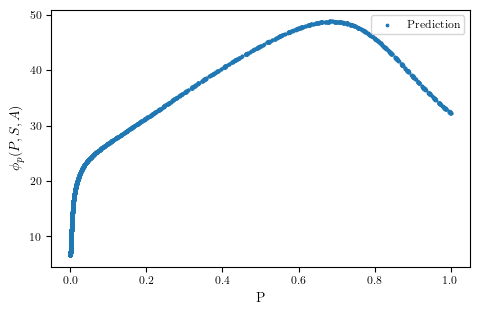

In [206]:
# plt.scatter(p, phi, s=3, label='Prediction')
plt.scatter(s, phi_s, s=3, label='Prediction')

# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi_p(P,S,A)$')
# plt.savefig('figures/phi.pdf')
plt.show()

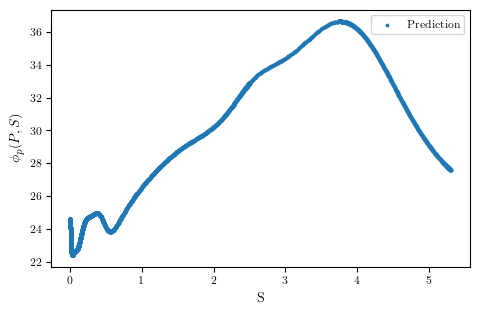

In [207]:
# plt.scatter(p, phi_s, s=3, label='Prediction')

plt.scatter(a, phi_a, s=3, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('S')
plt.ylabel('$\phi_p(P,S)$')
# plt.savefig('figures/phi.pdf')
plt.show()

In [208]:
n

array([5, 6, 5, 3])

In [209]:
k=3
p1[::L_exp][np.sum(n[:k]):np.sum(n[:k+1])]

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.00025261],
       [0.00025273],
       [0.00025289]], dtype=float32)>

In [210]:
p2[::L_exp]


<tf.Tensor: shape=(19, 1), dtype=float32, numpy=
array([[0.08206332],
       [0.08206766],
       [0.08202443],
       [0.08203738],
       [0.08202443],
       [0.08720129],
       [0.08714826],
       [0.08717714],
       [0.08716072],
       [0.08718849],
       [0.08719485],
       [0.09030668],
       [0.09031847],
       [0.09028537],
       [0.09030194],
       [0.09029014],
       [0.06197886],
       [0.06208987],
       [0.06223606]], dtype=float32)>

In [211]:
p1[::L_exp]

<tf.Tensor: shape=(19, 1), dtype=float32, numpy=
array([[0.00428492],
       [0.00428557],
       [0.00427908],
       [0.00428102],
       [0.00427908],
       [0.00117486],
       [0.00117402],
       [0.00117447],
       [0.00117421],
       [0.00117465],
       [0.00117475],
       [0.00054447],
       [0.00054422],
       [0.00054492],
       [0.00054457],
       [0.00054482],
       [0.00025261],
       [0.00025273],
       [0.00025289]], dtype=float32)>

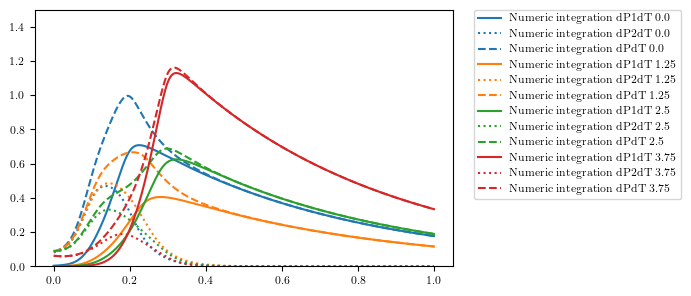

In [212]:
Nt=1000

# A_int=np.array([0,0.75, 1.25,2, 2.5,3,3.75])
# A_int=np.array([0, 1.25, 2.5, 3.75])

for k, a in enumerate(A):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    P1_int=np.zeros(Nt)
    P2_int=np.zeros(Nt)
    S_int=np.zeros(Nt)
    A_int=np.zeros(Nt)



    dt=0.001

    T_int[0]=0
    P1_int[0]=np.mean(p1[::L_exp][np.sum(n[:k]):np.sum(n[:k+1])]) #Initial conditions
    P2_int[0]=np.mean(p2[::L_exp][np.sum(n[:k]):np.sum(n[:k+1])]) #Initial conditions

    S_int[0]=np.array(s[0]) #Initial conditions
    A_int[0]=np.array(a) #Initial conditions

    for i in range(1,Nt):

        # PSL=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32), l],1)

        # REVISAAAAAR
        PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        PHI_A=tf.exp(predict(tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_a, b_a))

        P1_int[i]=P1_int[i-1]+(P1_int[i-1]*PHI_S - P1_int[i-1]*l)*dt
        P2_int[i]=P2_int[i-1]+(P2_int[i-1]*PHI_S - P2_int[i-1]*PHI_A)*dt
        S_int[i]=S_int[i-1]-(P1_int[i-1]+P2_int[i-1])*S_int[i-1]*np.array(ms)*dt
        A_int[i]=A_int[i-1]-P2_int[i-1]*A_int[i-1]*np.array(ma)*dt
        T_int[i]=T_int[i-1]+dt

    plt.plot(T_int, P1_int, color=colors[k], linestyle='-', label=f'Numeric integration dP1dT {a}')
    plt.plot(T_int, P2_int, color=colors[k], linestyle=':', label=f'Numeric integration dP2dT {a}')
    plt.plot(T_int, P1_int+P2_int, color=colors[k], linestyle='--', label=f'Numeric integration dPdT {a}')

    # plt.plot(T_int, S_int,  linestyle='--', label=f'Numeric integration dSdT {a}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.ylim(0,1.5)
plt.show()

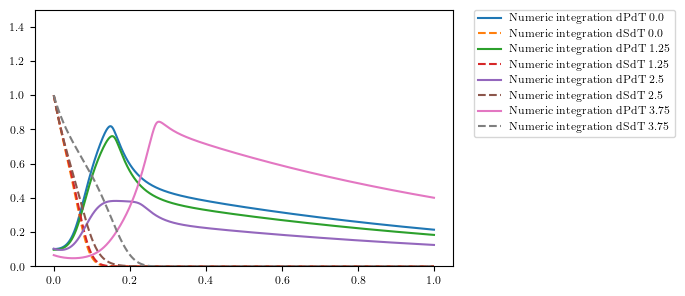

In [ ]:
Nt=1000

# A_int=np.array([0,0.75, 1.25,2, 2.5,3,3.75])
A_int=np.array([0, 1.25, 2.5, 3.75])

for k, a in enumerate(A_int):

    T_int=np.zeros(Nt)
    P_int=np.zeros(Nt)
    P1_int=np.zeros(Nt)
    P2_int=np.zeros(Nt)
    S_int=np.zeros(Nt)


    dt=0.001

    T_int[0]=0
    P1_int[0]=np.mean(p1[::L_exp][np.sum(n[:k]):np.sum(n[:k+1])]) #Initial conditions
    P2_int[0]=np.mean(p2[::L_exp][np.sum(n[:k]):np.sum(n[:k+1])]) #Initial conditions

    S_int[0]=np.array(s[0]) #Initial conditions
    l2=tf.exp(predict(tf.convert_to_tensor(a.reshape([-1,1]), dtype=tf.float32), W_a, b_a))
    for i in range(1,Nt):

        # PSL=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32), l],1)

        # REVISAAAAAR
        PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
        P1_int[i]=P1_int[i-1]+(P1_int[i-1]*PHI_S - P1_int[i-1]*l1)*dt
        P2_int[i]=P2_int[i-1]+(P2_int[i-1]*PHI_S - P2_int[i-1]*l2)*dt
        S_int[i]=S_int[i-1]-(P1_int[i-1]+P2_int[i-1])*S_int[i-1]*np.array(m)*dt
        T_int[i]=T_int[i-1]+dt

    # plt.plot(T_int, P1_int,  linestyle='-', label=f'Numeric integration dP1dT {a}')
    # plt.plot(T_int, P2_int,  linestyle=':', label=f'Numeric integration dP2dT {a}')
    plt.plot(T_int, P1_int+P2_int,  linestyle='-', label=f'Numeric integration dPdT {a}')

    plt.plot(T_int, S_int,  linestyle='--', label=f'Numeric integration dSdT {a}')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.ylim(0,1.5)
plt.show()